In [1]:
%load_ext autoreload
%autoreload 2

In [57]:
# a whole lot of great packages to import
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import glasbey


# just customizing some matlab parameters
palette = {
    "green": "#558150",
    "beige": "#F1E2C3",
    "brown": "#A7785A",
    "pink": "#F0D6C2",
    "black": "#0E0E0E",
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"   # make the background transparent
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.framealpha'] = 0.2
rcParams['axes.edgecolor'] = palette["black"]
rcParams['axes.labelcolor'] = palette["black"]
rcParams['xtick.color'] = palette["black"]
rcParams['ytick.color'] = palette["black"]
rcParams['text.color'] = palette["black"]
rcParams['axes.titlecolor'] = palette["black"]

cpal = sns.cubehelix_palette(start=-0.25, rot=2, as_cmap=True)
g_palette = glasbey.create_palette()  # glasbey is good for showing off segmentations
g_palette[0] = "#000000"
g_map = ListedColormap(g_palette)
blue_palette = sns.cubehelix_palette(as_cmap=True, rot=-.25, light=.7)

In [18]:
# using the pathlib library to make paths easier to work with
# obviously, you'll need to change this to wherever you have the data
datapath = Path(r"D:\OneDrive - Princeton University\Tracking\For Harrison_Cellpose_data\For Harrison")

# doing everything twice was just for the sake of a quick demo,
# you'll want a for loop or something in a real script
# or you can just use this for visualization, and delete everything with a 1 at the end
dapi1 = tifffile.imread(datapath / r"D2_series-18_DAPI.tif")
dapi2 = tifffile.imread(datapath / r"D3_series-06_DAPI.tif")

edu1 = tifffile.imread(datapath / r"D2_series-18_EdU.tif")
edu2 = tifffile.imread(datapath / r"D3_series-06_EdU.tif")

masks1 = tifffile.imread(datapath / r"D2_series-18_DAPI_s_cp_masks.tif")
masks2 = tifffile.imread(datapath / r"D3_series-06_DAPI_s_cp_masks.tif")

# cellpose saves masks as floats, but that's weird because they're really just integers
# we convert them to integers for compatability with other functions
masks1 = np.array(masks1, dtype=np.uint16)
masks2 = np.array(masks2, dtype=np.uint16)


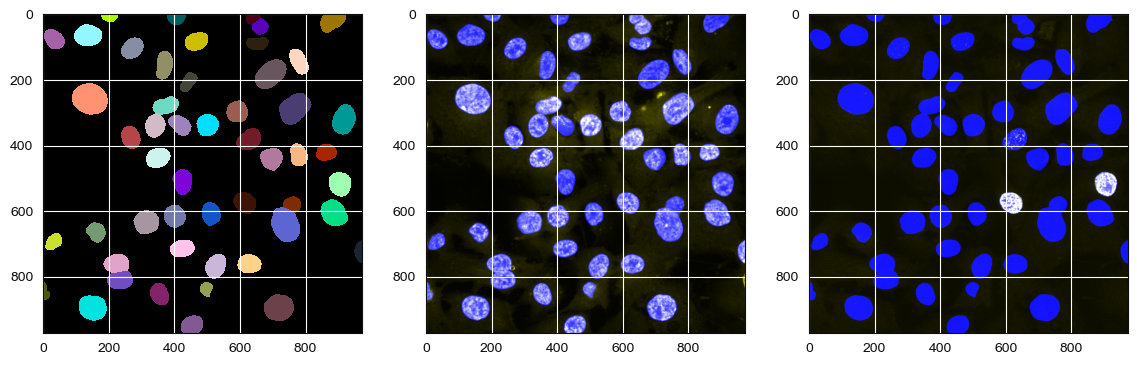

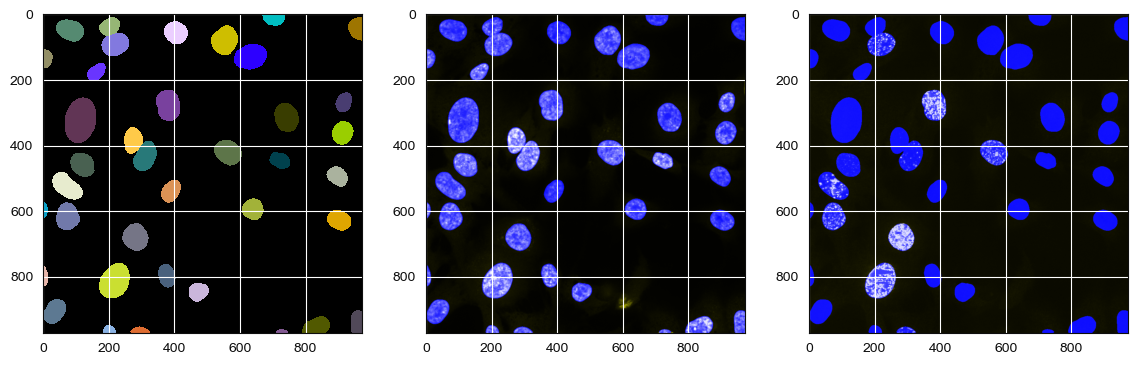

In [50]:
# rescale data for compatability with imshow
dapi1 = dapi1 / dapi1.max()
dapi2 = dapi2 / dapi2.max()

edu1 = edu1 / edu1.max()
edu2 = edu2 / edu2.max()

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
# np.stack is a quick way to combine channels
axes[0].imshow(masks1, cmap=g_map, interpolation="none")   # just masks
axes[1].imshow(np.stack([dapi1, dapi1, masks1>0], axis=-1))   # masks with dapi
axes[2].imshow(np.stack([edu1, edu1, masks1>0], axis=-1))   # masks with edu
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(masks2, cmap=g_map, interpolation="none")
axes[1].imshow(np.stack([dapi2, dapi2, masks2>0], axis=-1))
axes[2].imshow(np.stack([edu2, edu2, masks2>0], axis=-1))
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]


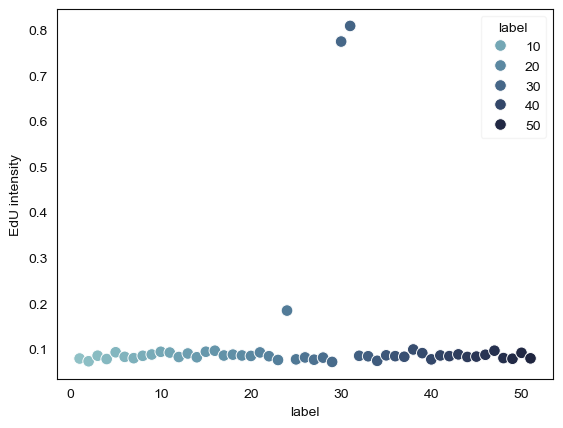

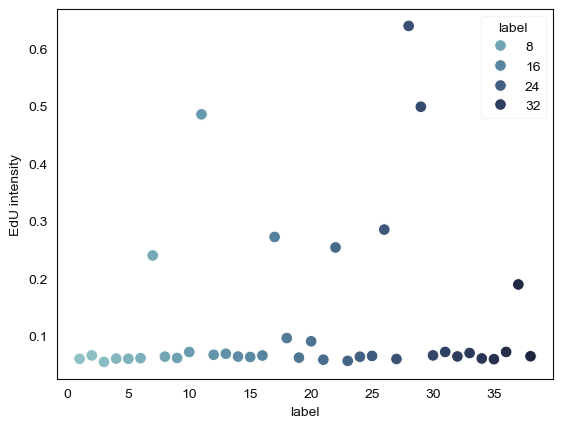

In [82]:
from skimage.measure import regionprops_table
## this is a useful function for getting properties of labeled regions

stack1 = np.stack([dapi1, edu1], axis=-1)
stack2 = np.stack([dapi2, edu2], axis=-1)

print(np.unique(masks1))

# we're getting the properties of the labeled regions putting them into a pandas dataframe
props1 = pd.DataFrame(regionprops_table(masks1, intensity_image=stack1, properties=("label", "area", "mean_intensity")))
props2 = pd.DataFrame(regionprops_table(masks2, intensity_image=stack2, properties=("label", "area", "mean_intensity")))

# seaborn (sns) lets us plot dataframes easily
sns.scatterplot(props1, x="label", y="mean_intensity-1", hue="label", palette=blue_palette, s=70)
plt.ylabel("EdU intensity")
plt.show()

sns.scatterplot(props2, x="label", y="mean_intensity-1", hue="label", palette=blue_palette, s=70)
plt.ylabel("EdU intensity")
plt.show()

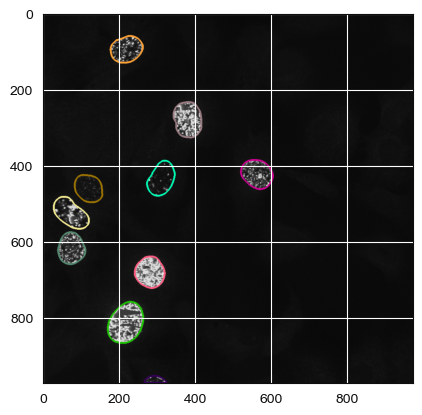

In [84]:
import cv2   # pip install opencv-python

# this code is almost worth ignoring because there's so many variables that
# you have to replace if you want to display a different image
# everything with a 2 at the end

# again, just for a quick demo, not good coding practice

def hextorgb(hex):
    hex = hex.lstrip("#")
    return tuple(int(hex[i:i+2], 16) for i in (0, 2, 4))

rgb = np.stack([edu2, edu2, edu2], axis=-1)
rgb = (np.clip(rgb, 0, 1) * 255).astype(np.uint8)

for i, cell in props2.iterrows():
    if cell["mean_intensity-1"] < 0.08:
        continue

    label = cell["label"]
    mask = masks2 == label
    
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(rgb, contours, -1, hextorgb(g_palette[int(label)]), 3)
    
    
plt.imshow(rgb)
plt.savefig(datapath/ "eduthresh.png")
plt.show()
